In [2]:
#The basics
import pandas as pd
import numpy as np
import json

#Plotting
import matplotlib.pyplot as plt
import FCPython 

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Decide which league to load
#Wyscout data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
with open('wyscoutEvents/events_England.json') as f:
    data = json.load(f)

In [3]:
#Create a data set of shots.
train = pd.DataFrame(data)
#only want the shots
shots=train[train['subEventName']=='Shot']
#create empty data frame
shots_model=pd.DataFrame(columns=['Goal','X','Y'])

In [4]:
#explainables
print(train.columns)
print(pd.unique(train['subEventName']))
print(train['tags'])

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'],
      dtype='object')
['Simple pass' 'High pass' 'Head pass' 'Air duel' 'Ground loose ball duel'
 'Smart pass' 'Launch' 'Ground defending duel' 'Ground attacking duel'
 'Foul' 'Free Kick' 'Cross' 'Shot' 'Reflexes' 'Touch' 'Clearance'
 'Ball out of the field' 'Throw in' 'Goal kick' 'Corner'
 'Goalkeeper leaving line' 'Hand pass' 'Acceleration' 'Save attempt' ''
 'Free kick cross' 'Free kick shot' 'Hand foul' 'Violent Foul' 'Protest'
 'Whistle' 'Late card foul' 'Out of game foul' 'Penalty' 'Time lost foul'
 'Simulation']
0                                            [{'id': 1801}]
1                                            [{'id': 1801}]
2                                            [{'id': 1801}]
3                                            [{'id': 1801}]
4                                            [{'id': 1801}]
                   

In [5]:

#Go through the dataframe and calculate X, Y co-ordinates.
#Distance from a line in the centre
#Shot angle.
#Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events
for i,shot in shots.iterrows():
    #print(shot)
    header=0
    for shottags in shot['tags']:#see this https://support.wyscout.com/matches-wyid-events
        if shottags['id']==403:
            header=1
    #Only include non-headers
    #shooting LEFT to RIGHT
    #bottom left corner is the (0,0) origin
    #if not(header):
    if header:
        #change x coordinate distance from goal
        shots_model.at[i,'X']=100-shot['positions'][0]['x']#use .at to access single value, similar to .loc
        #y coordinate unchanged
        shots_model.at[i,'Y']=shot['positions'][0]['y']#2 dictionary within a list, keys = 'x','y'
        #to get the distance shot to the center line
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        #x and y data are actually percentage of field.
        #in order to get actual meters divide by hundered to get fraction then mulitply by the dimensions
        #105by65
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        #Euciledean Distance
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        #angle
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

In [5]:
print(shots_model)

       Goal   X   Y     C   Distance     Angle
46        1  12  41   9.0  13.891814  0.474451
62        0  15  52   2.0  15.803560  0.453823
128       0  19  33  17.0  22.805811  0.280597
249       0  25  30  20.0  29.292704  0.223680
394       0  10  39  11.0  12.703248  0.479051
...     ...  ..  ..   ...        ...       ...
642939    0  14  40  10.0  16.072959  0.413920
642945    0  28  45   5.0  29.579089  0.244789
643023    1  14  33  17.0  18.390011  0.319916
643051    0  12  62  12.0  14.818907  0.420593
643055    0   8  38  12.0  11.462984  0.480357

[7134 rows x 6 columns]


In [6]:
#Two dimensional histogram
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])

#think of a mountain, x and y planes and the height is the frequency of that particular x and y

In [40]:
len(H_Shot[0])

20

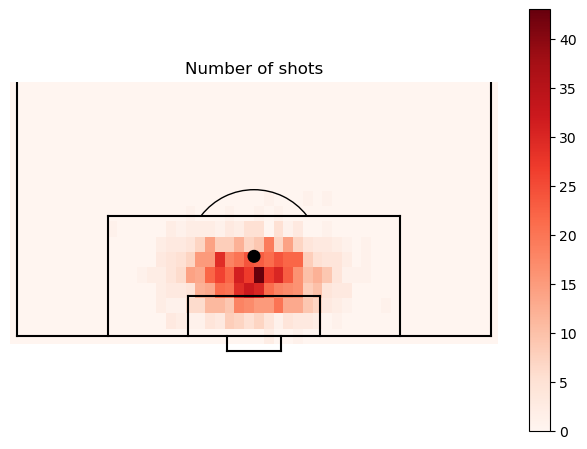

In [7]:
#Plot the number of shots from different points
(fig,ax) = FCPython.createGoalMouth()
#imshow is the method used to soa acolour scale based on 2d data
#extent is for the position on the pot
#cmap = mapping colours
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/NumberOfShots.pdf', dpi=None, bbox_inches="tight")   

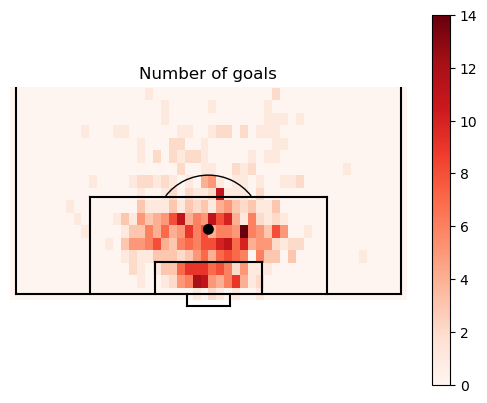

In [25]:

#Plot the number of GOALS from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0],shots_model[''] extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
#this next 2 statement is about the size of the graph/ picture and fitting it nicely to the page
plt.tight_layout()
#gca somethinf about axes
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/NumberOfGoals.pdf', dpi=None, bbox_inches="tight")   


/tmp/ipykernel_4222/2039685098.py:3: RuntimeWarning: invalid value encountered in divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)


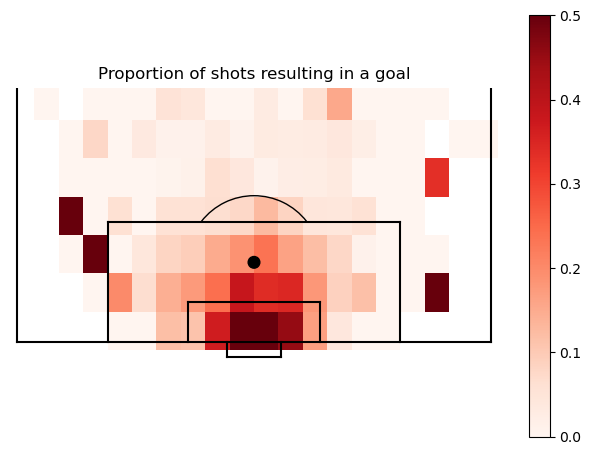

In [38]:
#Plot the probability of scoring from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/ProbabilityOfScoring.pdf', dpi=None, bbox_inches="tight")   

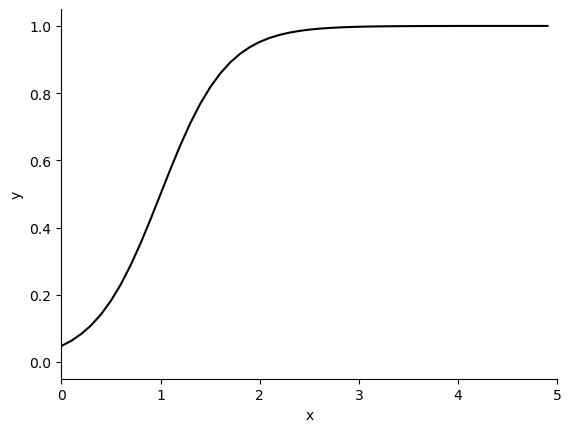

In [45]:
"""
logistic regression curve example
"""

#Plot a logistic curve
b=[3, -3]
x=np.arange(5,step=0.1)
y=1/(1+np.exp(b[0]+b[1]*x))
fig,ax=plt.subplots(num=1)
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x") 
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


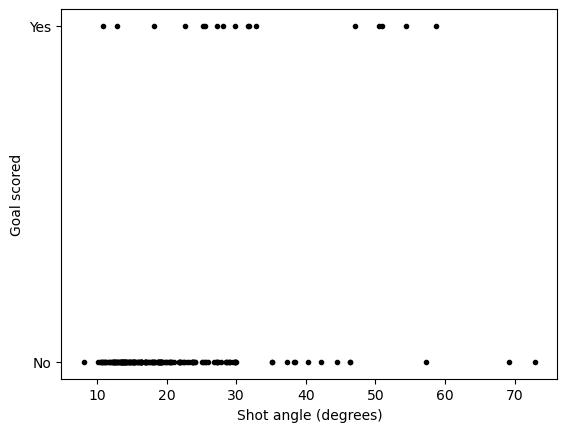

In [48]:

#Get first 200 shots
shots_200=shots_model.iloc[:200]

#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

(array([[17.,  4.,  3.,  2.,  4.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  1.,
          0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          2.]]),
 array([  0.  ,   3.75,   7.5 ,  11.25,  15.  ,  18.75,  22.5 ,  26.25,
         30.  ,  33.75,  37.5 ,  41.25,  45.  ,  48.75,  52.5 ,  56.25,
         60.  ,  63.75,  67.5 ,  71.25,  75.  ,  78.75,  82.5 ,  86.25,
         90.  ,  93.75,  97.5 , 101.25, 105.  , 108.75, 112.5 , 116.25,
        120.  , 123.75, 127.5 , 131.25, 135.  , 138.75, 142.5 , 146.25,
        150.  ]),
 <a list of 2 BarContainer objects>)

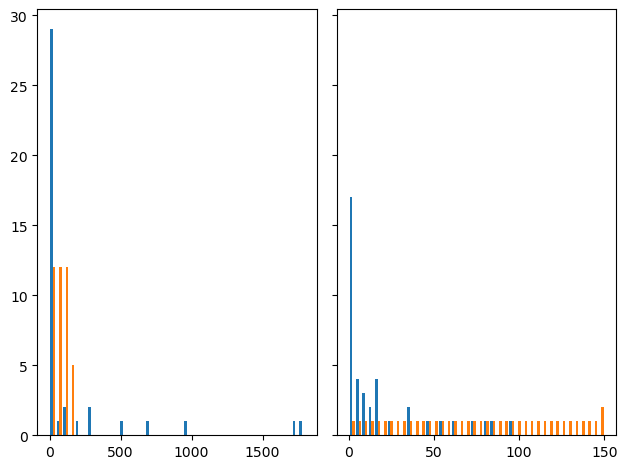

In [52]:
#Show empirically how goal angle predicts probability of scoring
#rad to degrees
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])


fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(shotcount_dist, bins=40)
axs[1].hist(goalcount_dist, bins=40)

In [58]:
#not exactly sure the point of this
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
print(angle[:-1])
print(angle[1:])
print(midangle)

[  0.     3.75   7.5   11.25  15.    18.75  22.5   26.25  30.    33.75
  37.5   41.25  45.    48.75  52.5   56.25  60.    63.75  67.5   71.25
  75.    78.75  82.5   86.25  90.    93.75  97.5  101.25 105.   108.75
 112.5  116.25 120.   123.75 127.5  131.25 135.   138.75 142.5  146.25]
[  3.75   7.5   11.25  15.    18.75  22.5   26.25  30.    33.75  37.5
  41.25  45.    48.75  52.5   56.25  60.    63.75  67.5   71.25  75.
  78.75  82.5   86.25  90.    93.75  97.5  101.25 105.   108.75 112.5
 116.25 120.   123.75 127.5  131.25 135.   138.75 142.5  146.25 150.  ]
[  1.875   5.625   9.375  13.125  16.875  20.625  24.375  28.125  31.875
  35.625  39.375  43.125  46.875  50.625  54.375  58.125  61.875  65.625
  69.375  73.125  76.875  80.625  84.375  88.125  91.875  95.625  99.375
 103.125 106.875 110.625 114.375 118.125 121.875 125.625 129.375 133.125
 136.875 140.625 144.375 148.125]


/tmp/ipykernel_4222/51898986.py:4: RuntimeWarning: invalid value encountered in divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


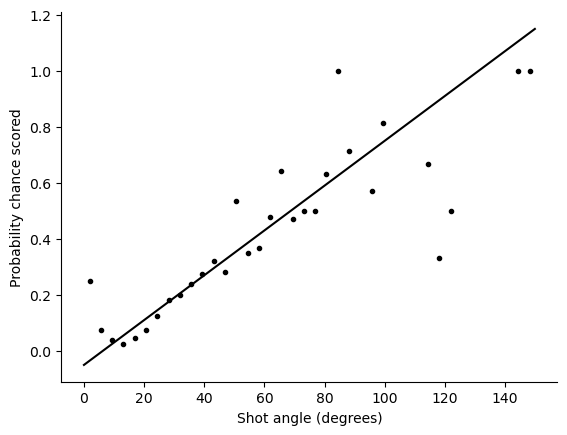

In [62]:

#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
#when only chose angle = for the plot you get this error
#ValueError: x and y must have same first dimension, but have shapes (41,) and (40,)
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.',color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Code commented out here, because only for illustrative purposes.
#Try some models by hand
#First try a linear model
#This is NOT a good model because a probability can't be less than zero or more than one
#Intercept and Slope
b=[-0.05, 1/125]
x=np.arange(150,step=0.1)
y= b[0] + b[1]*x 
ax.plot(x, y, linestyle='solid', color='black')

In [67]:

#Make single variable model of angle
#Using logistic regression we find the optimal values of b
#This process minimizes the loglikelihood
test_model = smf.glm(formula="Goal ~ Angle" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7132
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2056.3
Date:                    Thu, 13 Oct 2022   Deviance:                       4112.7
Time:                            15:14:20   Pearson chi2:                 6.70e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.08377
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

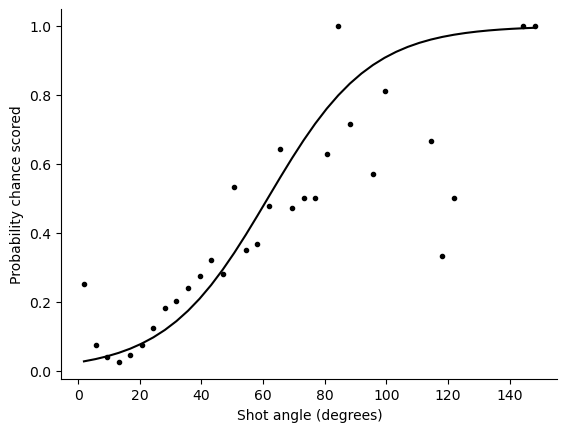

In [71]:
#plotting the probabilty of scoring using angle
xGprob=1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
#fig.savefig('Output/ProbabilityOfScoringAngleFit.pdf', dpi=None, bbox_inches="tight")   




/tmp/ipykernel_4222/240627848.py:7: RuntimeWarning: invalid value encountered in divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


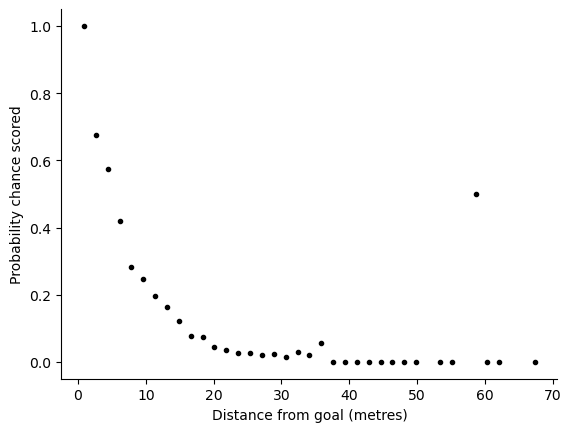

In [72]:
#Now lets look at distance from goal


#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [74]:
#Make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7132
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2010.7
Date:                    Thu, 13 Oct 2022   Deviance:                       4021.3
Time:                            15:17:41   Pearson chi2:                 1.90e+04
No. Iterations:                         6   Pseudo R-squ. (CS):            0.09542
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/tmp/ipykernel_4222/2793716733.py:8: RuntimeWarning: invalid value encountered in divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


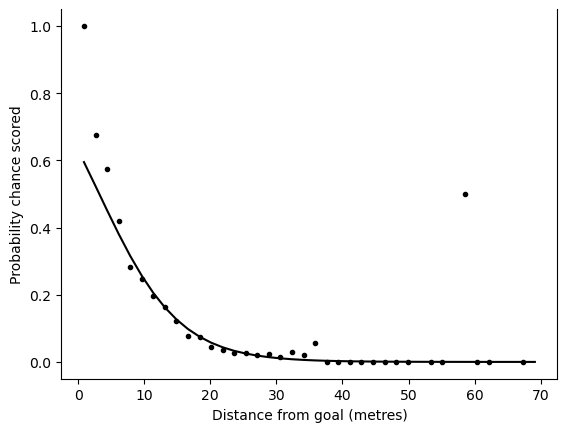

In [78]:
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
#Now lets look at distance from goal


#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7131
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1992.2
Date:                    Thu, 13 Oct 2022   Deviance:                       3984.3
Time:                            15:21:15   Pearson chi2:                 7.12e+03
No. Iterations:                         7   Pseudo R-squ. (CS):             0.1001
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

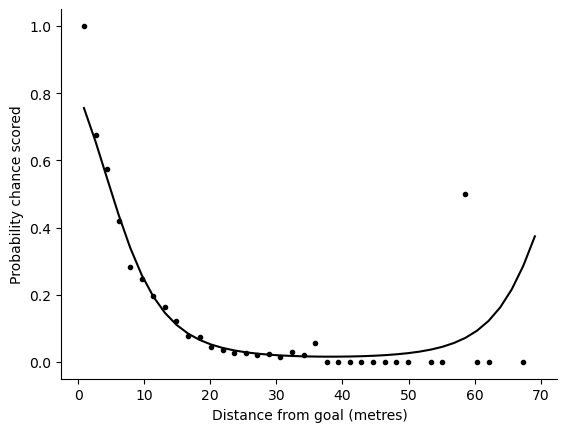

In [79]:
#Adding distance squared
squaredD = shots_model['Distance']**2
shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

In [82]:
#now looking at a function of both angle and distance

# A general model for fitting goal probability
# List the model variables you want here
model_variables = ['Angle','Distance']#,'X','C']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]
print(model)

Angle + Distance


In [83]:

#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7131
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1990.9
Date:                    Thu, 13 Oct 2022   Deviance:                       3981.8
Time:                            15:24:08   Pearson chi2:                 9.02e+03
No. Iterations:                         7   Pseudo R-squ. (CS):             0.1004
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [95]:
#Return xG value for more general model
#sh = row of the shots_model df
#%%capture
def calculate_xG(sh):
#sh = shots_model.iloc[1,:]
    bsum=b[0]
    for i,v in enumerate(model_variables):
        print(sh[v])
        bsum=bsum+b[i+1]*sh[v]
    xG = 1/(1+np.exp(bsum)) 
    return xG   
#xG
#Add an xG to my dataframe
#usiong apply function, only works if input to the function is a row




In [106]:
%%capture
xG=shots_model.apply(calculate_xG, axis=1)
shots_model = shots_model.assign(xG=xG)

0.0
32.5
0.0
31.5
0.0
30.5
0.0
29.5
0.0
28.5
0.0
27.5
0.0
26.5
0.0
25.5
0.0
24.5
0.0
23.5
0.0
22.5
0.0
21.5
0.0
20.5
0.0
19.5
0.0
18.5
0.0
17.5
0.0
16.5
0.0
15.5
0.0
14.5
0.0
13.5
0.0
12.5
0.0
11.5
0.0
10.5
0.0
9.5
0.0
8.5
0.0
7.5
0.0
6.5
0.0
5.5
0.0
4.5
-0.0
3.5
-0.0
2.5
-0.0
1.5
-0.0
0.5
-0.0
0.5
-0.0
1.5
-0.0
2.5
-0.0
3.5
0.0
4.5
0.0
5.5
0.0
6.5
0.0
7.5
0.0
8.5
0.0
9.5
0.0
10.5
0.0
11.5
0.0
12.5
0.0
13.5
0.0
14.5
0.0
15.5
0.0
16.5
0.0
17.5
0.0
18.5
0.0
19.5
0.0
20.5
0.0
21.5
0.0
22.5
0.0
23.5
0.0
24.5
0.0
25.5
0.0
26.5
0.0
27.5
0.0
28.5
0.0
29.5
0.0
30.5
0.0
31.5
0.007012357295336272
32.515380975778214
0.007470358690251872
31.51586901863885
0.007974952035621
30.516389039334257
0.00853270945482002
29.516944286290883
0.009151410122879145
28.5175384631984
0.009840317848153748
27.518175811634027
0.010610536504855177
26.51886121235224
0.011475469452535206
25.51960031034969
0.012451419439482952
24.520399670478458
0.01355838064868873
23.521266972678152
0.014821097088025613
22.5222112591104

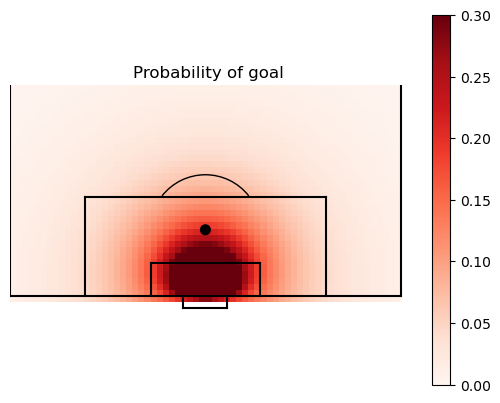

In [108]:
#Create a 2D map of xG
#therefore getting the xG for every possible position on the pitch
#create a df with the fake xs, and ys and hence angles

pgoal_2d=np.zeros((65,65))

for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        #sh['D2'] = x**2 + abs(y-65/2)**2
        #sh['X'] = x
        #sh['AX'] = x*a
        #sh['X2'] = x**2
        #sh['C'] = abs(y-65/2)
        #sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()